In [1]:
import pandas as pd
import numpy as np
import sys, os

import matplotlib.pyplot as plt

### Data

In [2]:
df = pd.read_csv("data/filtered_tsla_options_w_greeks.csv")
df = df[df.date_current == '2020-07-13']

In [3]:
df.head()

,date_current,ticker,expiration_date,days_to_expiry,option_id,option_type,strike_price,bid_price,option_price,ask_price,...,vega,rho,vanna,vomma,charm,veta,speed,zomma,color,ultima
0,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C232,C,232.0,81.38,83.92,84.76,...,0.270787,0.168850,-0.001107,0.092721,0.001670,0.004870,-0.000026,-0.001219,-0.000018,-0.233596
1,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C234,C,234.0,79.70,126.27,83.30,...,0.275230,0.168816,-0.001093,0.089479,0.001638,0.004869,-0.000026,-0.001305,-0.000020,-0.230026
2,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C236,C,236.0,78.69,88.73,82.30,...,0.281300,0.167491,-0.001033,0.081835,0.001562,0.004845,-0.000026,-0.001384,-0.000021,-0.214270
3,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C238,C,238.0,77.10,89.68,80.72,...,0.285528,0.167463,-0.001018,0.078803,0.001528,0.004843,-0.000026,-0.001472,-0.000022,-0.210680
4,2020-07-13,TSLA,2020-08-21,39.0,TSLA 2020-08-21 C240,C,240.0,75.80,77.60,79.60,...,0.290668,0.166610,-0.000973,0.073149,0.001464,0.004827,-0.000026,-0.001552,-0.000023,-0.199588


### Get regular expirations

In [4]:
start = "2020-07-13"
end = f"{int(start[:4]) + 4}-{start[4:]}"
fridays = pd.date_range(start, end, freq="WOM-3FRI").astype(str)
thursdays = pd.date_range(start, end, freq="WOM-3THU").astype(str)
regulars = list(fridays) + list(thursdays)

In [5]:
dfreg = df[df.expiration_date.isin(regulars)]
# Remove first and last two. Dont want the expiration in 2 days but also dont want the 2 year expirations
regulars = dfreg.expiration_date.unique()[1:-2]
days = dfreg.days_to_expiry.unique()[1:-2]

In [6]:
expiration_pairs = []
for i in range(len(regulars)):
    for reg, day in zip(regulars[i:], days[i:]):
        
        if regulars[i] == reg:
            continue
        expiration_pairs.append([regulars[i], reg, days[i], day])

### Check Pairs

In [7]:
cols = ['strike_price', 'delta', 'vega', 'theta', 'gamma']
ocols = ['delta_x', 'vega_x', 'theta_x', 'gamma_x', 'delta_y', 'vega_y', 'theta_y', 'gamma_y']

positions = []

for pair in expiration_pairs:
        
    e1, e2, day1, day2 = pair
    d1 = dfreg[dfreg.expiration_date == e1]
    d2 = dfreg[dfreg.expiration_date == e2]
    
    d1c = d1[d1.option_type == 'C'][cols]
    d1p = d1[d1.option_type == 'P'][cols]
    
    d2c = d2[d2.option_type == 'C'][cols]
    d2p = d2[d2.option_type == 'P'][cols]
    
    calls = d1c.merge(d2c, on='strike_price', how='inner')
    puts = d1p.merge(d2p, on='strike_price', how='inner')
    
    puts['moneyness'] = ((1 - puts.strike_price / 299.41) * 100).round(0)
    calls['moneyness'] = ((calls.strike_price / 299.41 - 1) * 100).round(0)
    
    puts['abs_moneyness'] = puts.moneyness.abs().reset_index(drop=True)
    calls['abs_moneyness'] = calls.moneyness.abs().reset_index(drop=True)
    
    puts = puts.drop_duplicates(subset=['moneyness'], keep='first')
    puts = puts.sort_values('moneyness')
    
    calls = calls.drop_duplicates(subset=['moneyness'], keep='first')
    calls = calls.sort_values('moneyness')
    
    puts = puts.drop(['abs_moneyness'], axis=1)
    calls = calls.drop(['abs_moneyness'], axis=1)
        
    puts.columns = ['strike_price'] + ['put_'+col for col in ocols] + ['moneyness']
    calls.columns = ['strike_price'] + ['call_'+col for col in ocols] + ['moneyness']
    
    legs = calls.merge(puts, on=['moneyness'], how='inner')
    pos = pd.DataFrame()
    
    pos['NetDelta'] = (legs.call_delta_y - legs.call_delta_x) + (legs.put_delta_y - legs.put_delta_x)
    pos['NetGamma'] = (legs.call_gamma_y - legs.call_gamma_x) + (legs.put_gamma_y - legs.put_gamma_x)
    pos['AbsDelta'] = pos.NetDelta.abs()
    
    pos['NetTheta'] = (legs.call_theta_x - legs.call_theta_y) + (legs.put_theta_x - legs.put_theta_y)
    pos['NetVega'] = (legs.call_vega_y - legs.call_vega_x) + (legs.put_vega_y - legs.put_vega_x)
    
    pos['CallStrike'] = legs.strike_price_x
    pos['PutStrike'] = legs.strike_price_y
    
    pos['Date1'] = e1
    pos['Date2'] = e2
    
    pos['Days1'] = day1
    pos['Days2'] = day2
    
    positions.append(pos)
    
positions = pd.concat(positions)

In [8]:
positions = positions.sort_values(['NetVega', 'AbsDelta'], ascending=[False, True])

In [9]:
delta_thresh = positions[positions.NetDelta <= 0.05]
delta_thresh['Ratio'] = delta_thresh.NetVega / (delta_thresh.AbsDelta + 1)

/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Track Top Position

In [10]:
data = pd.read_csv("data/tsla_options.csv")

In [11]:
position_legs = pd.DataFrame()
position_legs['LongCall'] = "TSLA " + delta_thresh.Date1 + " C" + delta_thresh.CallStrike.astype(int).astype(str)
position_legs['ShortCall'] = "TSLA " + delta_thresh.Date2 + " C" + delta_thresh.CallStrike.astype(int).astype(str)
position_legs['LongPut'] = "TSLA " + delta_thresh.Date1 + " P" + delta_thresh.PutStrike.astype(int).astype(str)
position_legs['ShortPut'] = "TSLA " + delta_thresh.Date2 + " P" + delta_thresh.PutStrike.astype(int).astype(str)
position_legs['Ratio'] = delta_thresh.Ratio

In [12]:
legs = position_legs.iloc[1, :]
legs = {leg : d for leg, d in zip(legs, [1, -1, 1, -1])}

In [13]:
ts = data[data.option_id.isin(legs.keys())]
ts['Direction'] = ts.option_id.map(legs)

/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
fl = ts[ts.date_current.isin(['2020-07-13', '2020-07-27'])]
fl_profit = fl.groupby('option_id').apply(lambda x: ((x.ask_price + x.bid_price) * 0.5).diff() * x.Direction)
fl_profit.dropna().sum()

-11.270000000000024

In [15]:
fl

,date_current,ticker,expiration_date,days_to_expiry,option_id,option_type,strike_price,bid_price,option_price,ask_price,implied_volatility,volume,open_interest,rate,stock_price,dividend_yield,Direction
699,2020-07-13,TSLA,2020-09-18,67,TSLA 2020-09-18 C242,C,242.0,80.80,87.64,84.40,105.54,1535,10,0.001247,299.41,0.0,1
1017,2020-07-13,TSLA,2021-01-15,186,TSLA 2021-01-15 C242,C,242.0,101.80,148.91,105.10,94.04,530,65,0.001503,299.41,0.0,-1
2227,2020-07-13,TSLA,2020-09-18,67,TSLA 2020-09-18 P356,P,356.0,92.20,73.68,95.78,110.49,90,25,0.001247,299.41,0.0,1
2512,2020-07-13,TSLA,2021-01-15,186,TSLA 2021-01-15 P356,P,356.0,109.39,201.07,111.45,85.89,35,20,0.001503,299.41,0.0,-1
31170,2020-07-27,TSLA,2020-09-18,53,TSLA 2020-09-18 C242,C,242.0,74.44,60.06,77.76,79.49,1525,25,0.001000,307.92,0.0,1
31507,2020-07-27,TSLA,2021-01-15,172,TSLA 2021-01-15 C242,C,242.0,94.80,89.80,98.12,77.54,520,10,0.001373,307.92,0.0,-1
32816,2020-07-27,TSLA,2020-09-18,53,TSLA 2020-09-18 P356,P,356.0,65.71,66.32,68.60,75.84,1000,2885,0.001000,307.92,0.0,1
33159,2020-07-27,TSLA,2021-01-15,172,TSLA 2021-01-15 P356,P,356.0,94.22,100.42,96.47,76.30,275,75,0.001373,307.92,0.0,-1


### Plot correspondance 

In [19]:
stats = []
for i in range(position_legs.shape[0]):
    
    legs = position_legs.iloc[i, :]
    legs = {leg : d for leg, d in zip(legs, [-1, 1, -1, 1])}
    
    ts = data[data.option_id.isin(legs.keys())]
    ts['Direction'] = ts.option_id.map(legs)
    
    fl = ts[ts.date_current.isin(['2020-07-13', '2020-07-27'])]
    fl_profit = fl.groupby('option_id').apply(lambda x: ((x.ask_price + x.bid_price) * 0.5).diff() * x.Direction)
    fl_profit = fl_profit.dropna().sum()
    
    stats.append([position_legs.iloc[i, :].Ratio, fl_profit])

/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


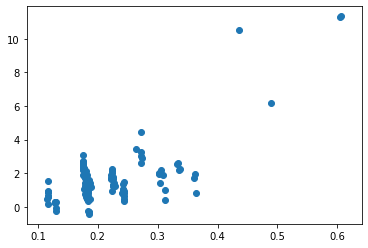

In [20]:
x, y = list(zip(*stats))
plt.scatter(x, y)
plt.show()